In [14]:
%pwd


'd:\\Documentation_sample'

In [2]:
import os

os.chdir("../")

In [3]:
%pwd

'd:\\Documentation_sample'

In [15]:
from dataclasses import dataclass
from pathlib import Path

@dataclass(frozen=True)
class TrainingConfig:
    root_dir: Path
    trained_model_path : Path
    base_model_path: Path
    train_loader_dir : Path
    valid_loader_dir :  Path
    params_batch_size : int
    params_valid_size : float
    params_learning_rate : float
    params_momentum: float
    params_image_dim : int
    params_random_seed: int
    params_epochs: int

In [16]:
from sample_project.constants import *
from sample_project.utils.common import read_yaml, create_directories
import torch

In [17]:
class ConfigurationManager:
    def __init__(
        self, 
        config_filepath = CONFIG_FILE_PATH,
        params_filepath = PARAMS_FILE_PATH):
        self.config = read_yaml(config_filepath)
        self.params = read_yaml(params_filepath)
        create_directories([self.config.artifacts_root])


    def get_training_config(self) -> TrainingConfig:
        training = self.config.training
        params = self.params
        create_directories([
            Path(training.root_dir)
        ])

        training_config = TrainingConfig(
            root_dir=Path(training.root_dir),
            trained_model_path=Path(training.trained_model_path),
            base_model_path=Path(training.base_model_path),
            train_loader_dir=Path(training.train_loader_dir),
            valid_loader_dir = Path(training.valid_loader_dir),
            params_epochs=params.EPOCHS,
            params_batch_size=params.BATCH_SIZE,
            params_learning_rate = params.LEARNING_RATE,
            params_momentum = params.MOMENTUM,
            params_image_dim = params.IMAGE_DIM,
            params_random_seed = params.RANDOM_SEED,
            params_valid_size = params.VALID_SIZE
        )

        return training_config


In [18]:
import os
import urllib.request as request
import zipfile
from sample_project import logger
from sample_project.utils.common import get_size
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torch.utils.data as data
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch

In [19]:

class Training:
    def __init__(self, config: TrainingConfig):
        self.config = config
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    def loading_iterators(self):
        self.train_iterator = torch.load(self.config.train_loader_dir)
        self.valid_iterator = torch.load(self.config.valid_loader_dir)

    def initializing_model(self):
        base_model = torch.load(self.config.base_model_path)
        torch.save(base_model, self.config.trained_model_path)
        self.model = torch.load(self.config.trained_model_path)
        self.model = self.model.to(self.device)  # Move model to the specified device
        self.loss_fn = nn.CrossEntropyLoss()

    def train(self):
        self.valid_accuracy, self.valid_loss = self.train_loop(self.model, self.train_iterator, self.valid_iterator,
                                                               self.config.params_epochs, self.config.params_learning_rate,
                                                               self.config.params_momentum, self.loss_fn)
        plt.subplot(1,2,1)
        plt.plot(self.valid_loss)
        plt.title("Validation Loss VS Number Of Epochs")
        plt.xlabel("Number of Epochs")
        plt.ylabel("Validation_Loss")

        plt.subplot(1,2,2)
        plt.plot(self.valid_accuracy)
        plt.title("Validation accuracy VS Number Of Epochs")
        plt.xlabel("Number of Epochs")
        plt.ylabel("Validation_accuracy")
        











    @staticmethod
    def train_loop(model, train_iterator, valid_iterator, epochs: int, learning_rate: float, momentum: float, Loss_function):

        def accuracy(Predictions,Actual_labels):
            predicted_labels = torch.argmax(Predictions,axis=1)
            accuracy = torch.count_nonzero(predicted_labels==Actual_labels)/ len(Actual_labels)
            return accuracy
        
        
        
        device = next(model.parameters()).device  # Get the device from the model

        n_iterations_per_epoch = len(train_iterator)
        n_iterations_validation = len(valid_iterator)

        best_loss_val = np.infty

        optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

        Valid_loss = []
        Valid_accuracy = []

        for epoch in range(epochs):
            model.train()

            for iteration, idata in enumerate(train_iterator, 1):
                inputs, targets = idata
                inputs, targets = inputs.to(device), targets.to(device)

                optimizer.zero_grad()

                outputs = model(inputs)

                loss = Loss_function(outputs, targets)

                loss.backward()

                optimizer.step()

                current_loss = loss.item()

                print("\rIteration: {}/{} ({:.1f}%)  Loss: {:.5f}".format(
                        iteration, n_iterations_per_epoch,
                        iteration * 100 / n_iterations_per_epoch,
                        current_loss),
                    end="")
                break

            model.eval()
            loss_vals = []
            acc_vals = []
            with torch.no_grad():
                for iteration, idata in enumerate(valid_iterator, 1):
                    inputs, targets = idata
                    inputs, targets = inputs.to(device), targets.to(device)
                    outputs = model(inputs)
                    current_loss = Loss_function(outputs, targets)
                    current_accuracy = accuracy(outputs, targets)
                    loss_vals.append(float(current_loss))
                    acc_vals.append(float(current_accuracy))
                    print("\rEvaluating the model: {}/{} ({:.1f}%) Loss: {:.5f} accuracy: {:.5f}".format(
                            iteration, n_iterations_validation,
                            iteration * 100 / n_iterations_validation, current_loss, current_accuracy),
                        end=" " * 10)
                    break


                loss_val = np.mean(loss_vals)
                acc_val = np.mean(acc_vals)

                Valid_loss.append(loss_val)
                Valid_accuracy.append(acc_val)

                print("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}".format(
                    epoch + 1, acc_val * 100, loss_val,
                    "(improved)" if loss_val < best_loss_val else ""))
                if epoch+1==epochs:
                    logger.info("\rEpoch: {}  Val accuracy: {:.4f}%  Loss: {:.6f}{}".format(
                    epoch + 1, acc_val * 100, loss_val))

                if loss_val < best_loss_val:
                    best_loss_val = loss_val
        

        return Valid_accuracy, Valid_loss


[2024-07-29 15:27:05,234: INFO: common: yaml file: config\config.yaml loaded successfully]
[2024-07-29 15:27:05,235: INFO: common: yaml file: params.yaml loaded successfully]
[2024-07-29 15:27:05,235: INFO: common: created directory at: artifacts]
[2024-07-29 15:27:05,235: INFO: common: created directory at: artifacts\training]
Epoch: 1  Val accuracy: 12.5000%  Loss: 2.302334(improved)].12500          [2024-07-29 15:27:06,251: INFO: 3633166554: 


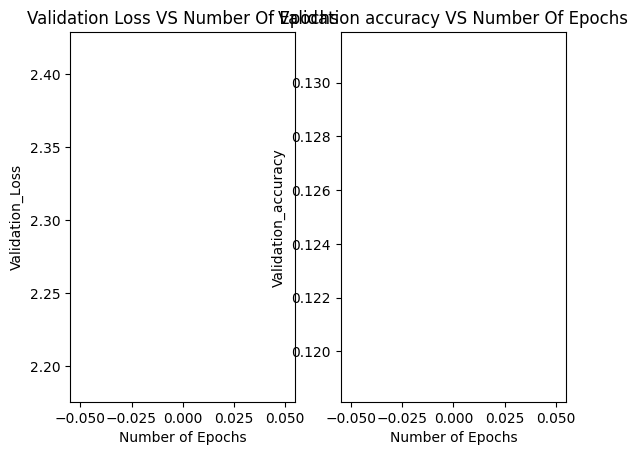

In [20]:
try:
    config = ConfigurationManager()
    Training_config = config.get_training_config()
    Training_step = Training(config=Training_config)
    Training_step.loading_iterators()
    Training_step.initializing_model()
    Training_step.train()
    
except Exception as e:
    raise e
